# Analyse Results

{
    "precision": 0.7559,
    "recall": 0.7592,
    "f1": 0.7156
}


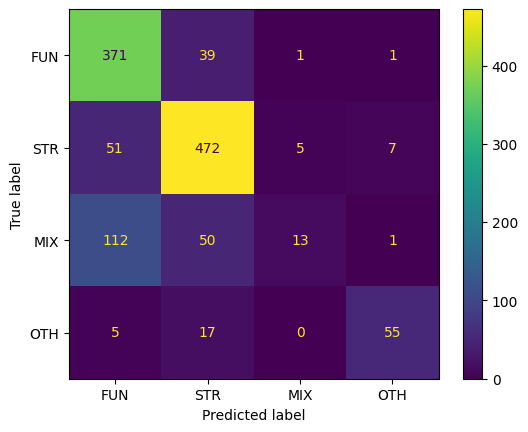

In [33]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
import ast
import json

# Set file to analyse
file_name = 'bert-for-patents-agreement-1200'
file_name = 'bert-large-uncased-agreement-1200'
file_name = 'test_10_10'

# Import data
#result_df = pd.read_excel(f"/home/fantoni/patent-sentence-classification/results/finetuning/{file_name}.xlsx")
result_df = pd.read_excel(f"/home/fantoni/patent-sentence-classification/results/incremental/{file_name}.xlsx")

# Set labels
labels = ['FUN', 'STR', 'MIX', 'OTH']
true_labels = result_df['sent_tag']  
predicted_labels = result_df['predicted_tag']

# Calculate classification metrics
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')
results = {
    'precision': round(precision, 4),  # Rounded for better readability
    'recall': round(recall, 4),
    'f1': round(f1, 4)
}
print(json.dumps(results, indent=4))  # Pretty-print the JSON

# Save Metrics as JSON
#output_file_path = f"/home/fantoni/patent-sentence-classification/results/finetuning/{file_name}.json"
#with open(output_file_path, "w") as f:
#    json.dump(results, f, indent=4)  # Save as formatted JSON

# Create Classification Report
#class_report = classification_report(true_labels, predicted_labels, labels=labels, target_names=labels)
#output_file_path = f"/home/fantoni/patent-sentence-classification/results/finetuning/{file_name}.txt"
#with open(output_file_path, "w") as f:
#    f.write("Classification Report:\n")
#    f.write(class_report)

# Create confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()

 # Confidence Cut-Off Analysis

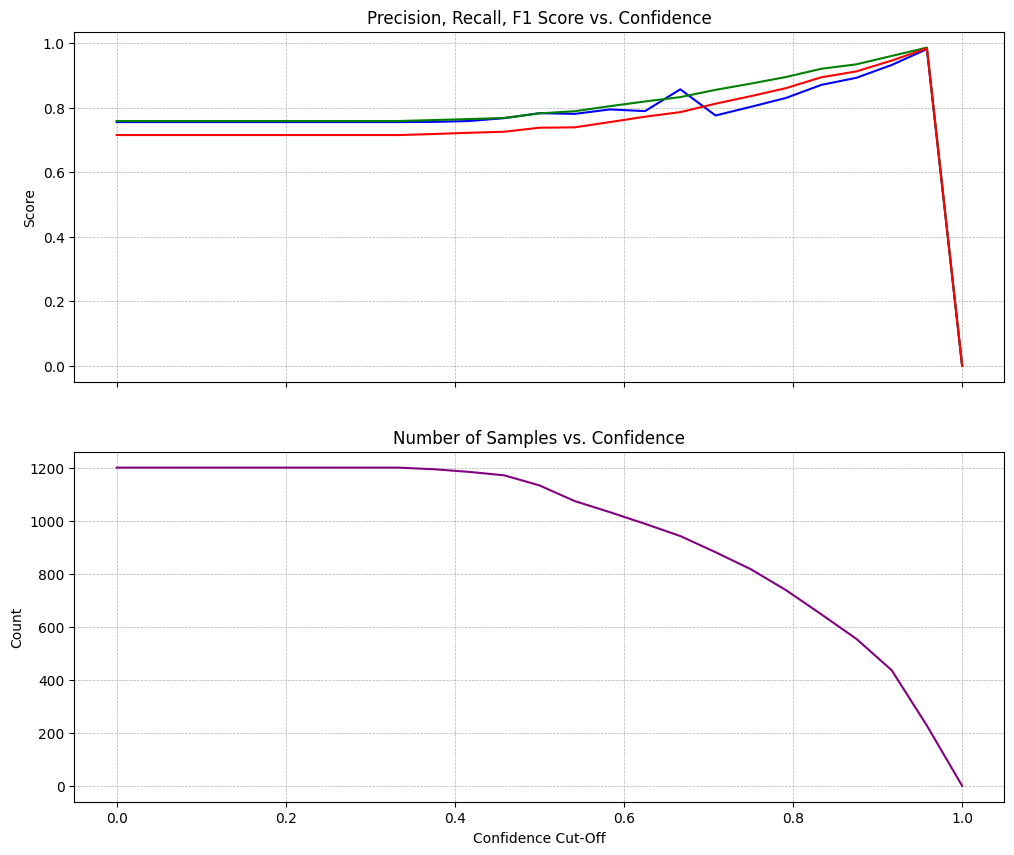

In [14]:
import numpy as np
from sklearn.metrics import precision_recall_fscore_support

# Extract the maximum probability per row
result_df['top_prob'] = result_df['probabilities'].apply(max)

# Define threshold range
thresholds = np.linspace(0, 1, 25)  # 10 steps from 0 to 0.90

# Initialize lists to store precision, recall, f1-score, and support values
precision_values = []
recall_values = []
f1_values = []
count_values = []

# Compute metrics for each threshold
for threshold in thresholds:
    # Filter based on threshold
    selected = result_df[result_df['top_prob'] >= threshold]    
    if selected.empty:
        precision_values.append(0)
        recall_values.append(0)
        f1_values.append(0)
        count_values.append(0)
    else:
        # Compute precision, recall, f1-score
        count = len(selected)
        precision, recall, f1, _ = precision_recall_fscore_support(selected['sent_class'], selected['predicted_class'], average='weighted', zero_division=0)
        precision_values.append(precision)
        recall_values.append(recall)
        f1_values.append(f1)
        count_values.append(count)

# Create figure and axes
fig, ax = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Plot precision, recall, F1-score
ax[0].plot(thresholds, precision_values, label="Precision", color='blue')
ax[0].plot(thresholds, recall_values, label="Recall", color='green')
ax[0].plot(thresholds, f1_values, label="F1 Score", color='red')
ax[0].set_ylabel("Score")
ax[0].set_title("Precision, Recall, F1 Score vs. Confidence")
ax[0].grid(True, which='both', linestyle='--', linewidth=0.5)

# Plot count values
ax[1].plot(thresholds, count_values, label="Count", color='purple')
ax[1].set_xlabel("Confidence Cut-Off")
ax[1].set_ylabel("Count")
ax[1].set_title("Number of Samples vs. Confidence")
ax[1].grid(True, which='both', linestyle='--', linewidth=0.5)

# Show the plot
plt.show()

# Agreement Analysis

In [ ]:
# Import agreement data
agreement_df = pd.read_excel("/home/fantoni/patent-sentence-classification/data/1200_agreement_All.xlsx", usecols=['sent_id', 'agreement'])

# Merge result with agreeement data
result_df = pd.merge(result_df, agreement_df, on='sent_id', how='left')

# Indetify Correct Prediction
result_df['correct'] = result_df['sent_class'] == result_df['predicted_class']

# Get max prob
result_df["probabilities"] = result_df["probabilities"].apply(ast.literal_eval) # import as a list
result_df['max_prob'] = result_df['probabilities'].apply(max)

#result_df

/tmp/ipykernel_430891/4200290355.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metrics_df = result_df.groupby("agreement").apply(compute_metrics).apply(pd.Series)


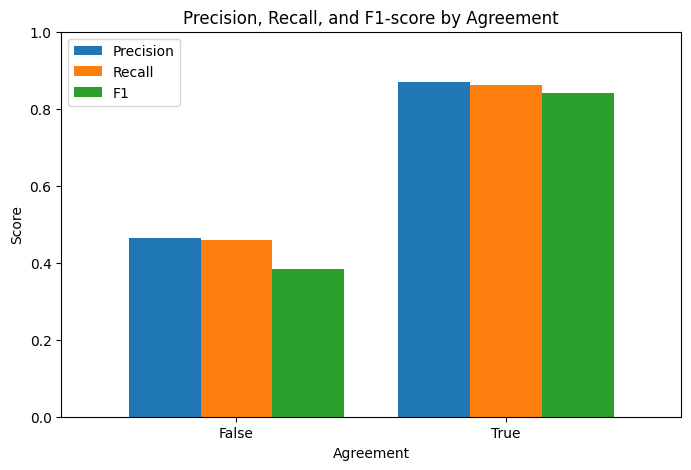

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support

def compute_metrics(group):
    #Calculate precision, recall, and F1-score for each agreement group.
    precision, recall, f1, _ = precision_recall_fscore_support(
        group["sent_class"], group["predicted_class"], average="weighted", zero_division=0
    )
    return {"Precision": precision, "Recall": recall, "F1": f1}

# Compute metrics grouped by agreement
metrics_df = result_df.groupby("agreement").apply(compute_metrics).apply(pd.Series)

# Plot metrics
fig, ax = plt.subplots(figsize=(8, 5))
metrics_df.plot(kind="bar", ax=ax, width=0.8)
plt.title("Precision, Recall, and F1-score by Agreement")
plt.ylabel("Score")
plt.xlabel("Agreement")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(title="")
plt.show()

/tmp/ipykernel_430891/3023781033.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=result_df, x='agreement', y='max_prob', palette={'True': 'green', 'False': 'red'}, boxprops=dict(alpha=0.5))


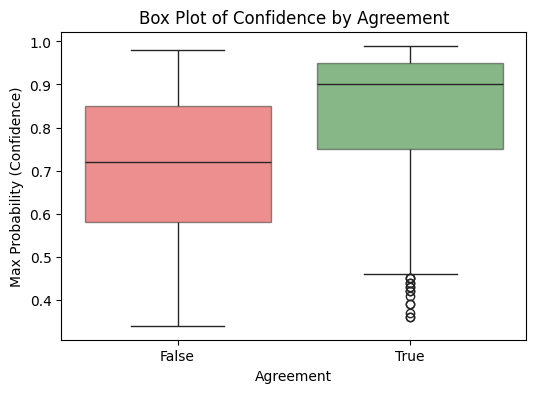

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.boxplot(data=result_df, x='agreement', y='max_prob', palette={'True': 'green', 'False': 'red'}, boxprops=dict(alpha=0.5))
plt.xlabel("Agreement")
plt.ylabel("Max Probability (Confidence)")
plt.title("Box Plot of Confidence by Agreement")
plt.show()

# Load Fine-tuned Model

In [4]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from src.model import PatentSentenceClassifier

/home/fantoni/miniconda3/envs/segmentation/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# Load the checkpoint
checkpoint_name = 'bert-for-patents-agreement-1200'
checkpoint_name = 'bert-large-uncased-agreement-1200'
checkpoint_path = f"/home/fantoni/patent-sentence-classification/models/{checkpoint_name}.ckpt"

# Set hyperparameters
model_name = "anferico/bert-for-patents"
model_name = "bert-large-uncased"
num_labels = 4

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load Tokenizer and Base Model
bert_tokenizer = BertTokenizer.from_pretrained(model_name)
base_model = BertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
print('\nTokenizer and Base Model loaded succesfully.')

# Load Finetuned Patent Model
loaded_model = PatentSentenceClassifier.load_from_checkpoint(checkpoint_path, model=base_model, tokenizer=bert_tokenizer)
loaded_model.eval()
loaded_model.to(device)
print('\nModel loaded succesfully.')

Using device: cpu


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Tokenizer and Base Model loaded succesfully.

Model loaded succesfully.


# Inference


Sentence: 'If there are no allocated cells to a hub using the previous criterion, the first allocated cell will be the closest cell to that hub.'
Predicted Class: FUN
Probabilities: [0.88, 0.06, 0.04, 0.02]


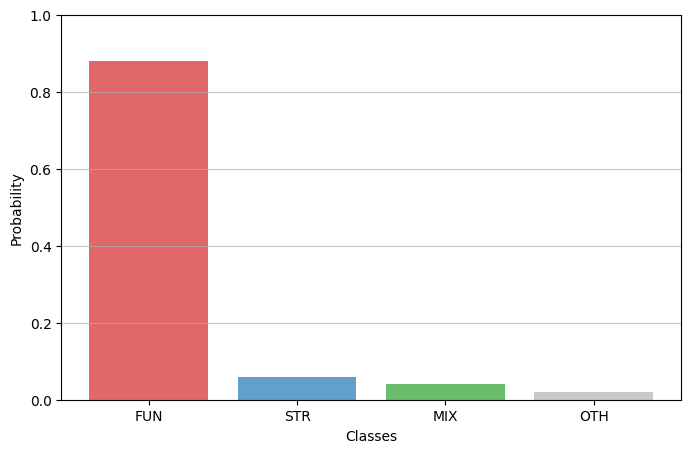

In [7]:
# Select Sentence
text_input = "Additionally, the stopper 108 is used at the distal end of the wire where the loop is formed to substantially secure the loop closed." # MIX
text_input = "Provisional Patent Application number 62/571,193; filed Oct. 11, 2017; and entitled INSECT VACUUM AND TRAP ATTACHMENT SYSTEMS." #OTH
text_input = "In some embodiments, the horizontal position of the idler support block 1213 may be adjustable to maintain tension on the chain 1212." #FUN
text_input = "The rigid foam layer 50 is typically selected from the group of polyurethane foams, polyurea foams, and combinations thereof." # STR
text_input = "If there are no allocated cells to a hub using the previous criterion, the first allocated cell will be the closest cell to that hub." #FUN

# Tokenize input
tokenizer = loaded_model.tokenizer  # Assuming tokenizer is part of the model
inputs = tokenizer(text_input, truncation=True, padding=True, max_length=512, return_tensors='pt')

# Perform inference on single sentence
inputs = {k: v.to(device) for k, v in inputs.items()}  # move input to same device
int_to_label = {0: 'FUN', 1: 'STR', 2: 'MIX', 3: 'OTH'}
with torch.no_grad():
    outputs = loaded_model(**inputs)
    probabilities = torch.nn.functional.softmax(outputs.logits, dim=1)
    predicted_class = torch.argmax(probabilities, dim=1)

result = {
    'predicted_class': int_to_label[predicted_class.item()],
    'probabilities': [round(prob, 2) for prob in probabilities[0].tolist()]
}

# Visulize Inference on single sentence
print(f"\nSentence: '{text_input}'\nPredicted Class: {result['predicted_class']}\nProbabilities: {result['probabilities']}")
labels = list(int_to_label.values())
colors = ['#d62728', '#1f77b4', '#2ca02c', '#b2b2b2']  # Red, Blue, Green, Gray

# Plot the bar plot
plt.figure(figsize=(8, 5))
plt.bar(labels, result['probabilities'], color=colors, alpha=0.7)
plt.xlabel("Classes", fontsize=10)
plt.ylabel("Probability", fontsize=10)
plt.ylim(0, 1)  # Probabilities are between 0 and 1
plt.grid(axis='y', alpha=0.7)
plt.show()